In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from gluonts.dataset.split import split
from gluonts.dataset.common import (
    MetaData,
    TrainDatasets,
    FileDataset,
)
plt.style.use('seaborn')

/tmp/ipykernel_40153/3732702600.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def get_custom_dataset(
    jsonl_path: Path,
    freq: str,
    prediction_length: int,
    split_offset: int = None,
):
    """Creates a custom GluonTS dataset from a JSONLines file and
    give parameters.

    Parameters
    ----------
    jsonl_path
        Path to a JSONLines file with time series
    freq
        Frequency in pandas format
        (e.g., `H` for hourly, `D` for daily)
    prediction_length
        Prediction length
    split_offset, optional
        Offset to split data into train and test sets, by default None

    Returns
    -------
        A gluonts dataset
    """
    if split_offset is None:
        split_offset = -prediction_length

    metadata = MetaData(freq=freq, prediction_length=prediction_length)
    test_ts = FileDataset(jsonl_path, freq)
    train_ts, _ = split(test_ts, offset=split_offset)
    dataset = TrainDatasets(metadata=metadata, train=train_ts, test=test_ts)
    return dataset

In [3]:
dataset = get_custom_dataset('datasets/msft_dataset.jsonl', freq='D', prediction_length=30)

In [4]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

# Initialize the DeepAR estimator
deepar_estimator = DeepAREstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
deepar_predictor = deepar_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:07<00:00, 12.87it/s, epoch=200/200, avg_epoch_loss=-4.38]


In [5]:
from gluonts.mx.model.transformer import TransformerEstimator

# Initialize the Transformer estimator
transformer_estimator = TransformerEstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
transformer_predictor = transformer_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:05<00:00, 17.60it/s, epoch=200/200, avg_epoch_loss=-3.76]


In [9]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

def evaluate_model(predictor, test_data):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test_data))

    for i, (ts_entry, forecast_entry) in enumerate(zip(tss, forecasts)):
        # Plot and save each time series and forecast comparison
        plt.figure(figsize=(10, 5))
        plt.plot(ts_entry[-150:].to_timestamp(), label='Actual')  # Adjust the slicing according to your data
        forecast_entry.plot(color='crimson', label='Forecast')
        plt.legend()
        plt.title(f'Forecast vs Actuals for Series {i}')
        # plt.savefig(os.path.join(output_dir, f'forecast_plot_{i}.png'))  # Save the plot as a PNG file
        plt.plot()

    return agg_metrics, item_metrics


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


DeepAR Evaluation Metrics: {'MSE': 0.00012655221701910098, 'abs_error': 0.2607441842556, 'abs_target_sum': 0.24775508046150208, 'abs_target_mean': 0.008258502682050068, 'seasonal_error': 0.019209156147546317, 'MASE': 0.45246510267085344, 'MAPE': 3.4054471333821614, 'sMAPE': 1.3484373728434245, 'MSIS': 4.5794782280061455, 'QuantileLoss[0.1]': 0.1606314423959702, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.2]': 0.20618320861831307, 'Coverage[0.2]': 0.3333333333333333, 'QuantileLoss[0.3]': 0.23353511225432155, 'Coverage[0.3]': 0.43333333333333335, 'QuantileLoss[0.4]': 0.25152529813349256, 'Coverage[0.4]': 0.5333333333333333, 'QuantileLoss[0.5]': 0.2607442084408831, 'Coverage[0.5]': 0.5333333333333333, 'QuantileLoss[0.6]': 0.2554231449030339, 'Coverage[0.6]': 0.6, 'QuantileLoss[0.7]': 0.23773286177311093, 'Coverage[0.7]': 0.6, 'QuantileLoss[0.8]': 0.20442727962508794, 'Coverage[0.8]': 0.7666666666666667, 'QuantileLoss[0.9]': 0.12276970813982187, 'Coverage[0.9]': 0.8, 'RMSE': 0.011249542969343287

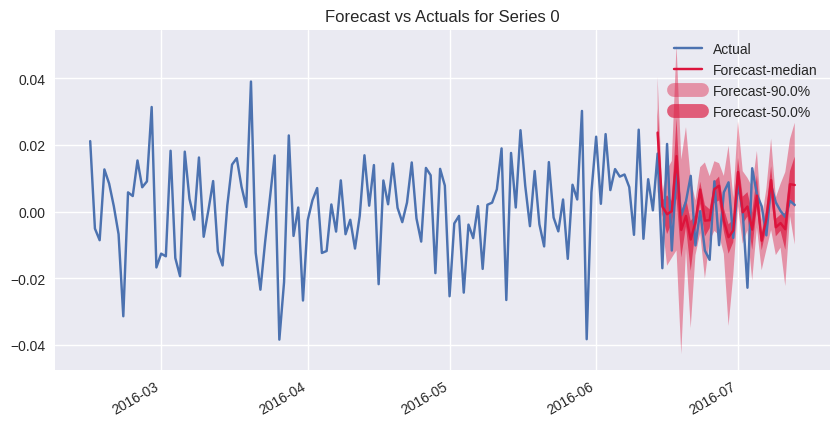

In [10]:
deepar_metrics, _ = evaluate_model(deepar_predictor, dataset.test)
print("DeepAR Evaluation Metrics:", deepar_metrics)


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Transformer Evaluation Metrics: {'MSE': 0.0001600785180926323, 'abs_error': 0.2997528910636902, 'abs_target_sum': 0.24775508046150208, 'abs_target_mean': 0.008258502682050068, 'seasonal_error': 0.019209156147546317, 'MASE': 0.5201562712442545, 'MAPE': 17.795365397135416, 'sMAPE': 1.457678985595703, 'MSIS': 6.2935770828609785, 'QuantileLoss[0.1]': 0.18158708403352647, 'Coverage[0.1]': 0.26666666666666666, 'QuantileLoss[0.2]': 0.24453993597999216, 'Coverage[0.2]': 0.3333333333333333, 'QuantileLoss[0.3]': 0.27527754229959095, 'Coverage[0.3]': 0.36666666666666664, 'QuantileLoss[0.4]': 0.30057400823570796, 'Coverage[0.4]': 0.4, 'QuantileLoss[0.5]': 0.2997528904234059, 'Coverage[0.5]': 0.43333333333333335, 'QuantileLoss[0.6]': 0.29467936921864746, 'Coverage[0.6]': 0.4666666666666667, 'QuantileLoss[0.7]': 0.2706788798794151, 'Coverage[0.7]': 0.5, 'QuantileLoss[0.8]': 0.2316155375912785, 'Coverage[0.8]': 0.5666666666666667, 'QuantileLoss[0.9]': 0.16841511770617218, 'Coverage[0.9]': 0.766666666

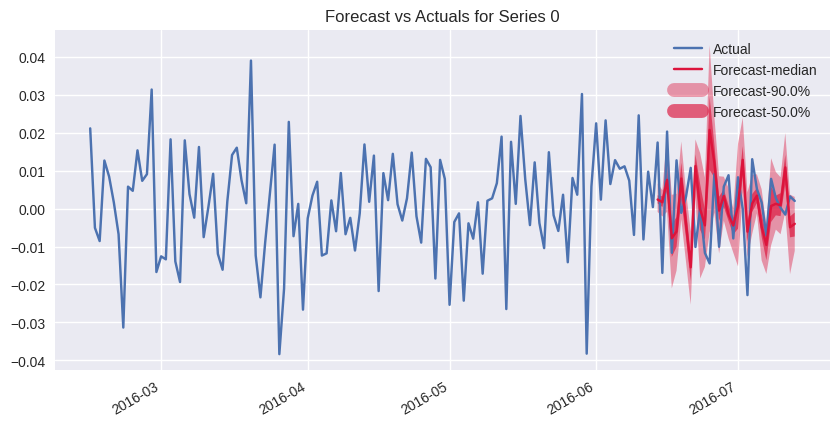

In [11]:
transformer_metrics, _ = evaluate_model(transformer_predictor, dataset.test)
print("Transformer Evaluation Metrics:", transformer_metrics)
